**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL.Image
import PIL.ImageDraw
import matplotlib.pyplot

from PIL import Image
import pandas as pd
import os

from torchvision.utils import draw_segmentation_masks
from torch.functional import Tensor

import cv2

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

currentDirPath = "./drive/MyDrive/Software udvikling/DeepLearning/Eksamen/"

**Helper methods**

In [ ]:
# def create_mask(bounding_box_coord, image):
#     """Creates a mask for the bounding box of same shape as image"""
#     *_,rows,cols = image.shape
#     mask = np.zeros((rows, cols))
#     bb = bounding_box_coord.astype(np.int)
#     mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
#     return mask

# def mask_to_bb(mask):
#     """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
#     cols, rows = np.nonzero(mask)
#     if len(cols)==0: 
#         return np.zeros(4, dtype=np.float32)
#     top_row = np.min(rows)
#     left_col = np.min(cols)
#     bottom_row = np.max(rows)
#     right_col = np.max(cols)
#     return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)
    
def create_bb_array(csvRow):
    """Generates bounding box array from a train_df row"""
    return np.array([csvRow['ymin'],csvRow['xmin'],csvRow['ymax'],csvRow['xmax']])

# def resize_image_bb(read_path,row,size):
#     """Resize an image and its bounding box and write image to new path"""
#     bounding_box = create_bb_array(row)
#     img = read_image(read_path)
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize(size),
#         transforms.ToTensor()
#     ])
#     im_resized = transform(img)
#     #print(im_resized.shape)
#     mask = create_mask(bounding_box, img)
#     #print(mask.shape)
#     Y_resized = cv2.resize(mask, size)
#     #print(Y_resized)
#     #new_path = currentDirPath + write_path + row['img_id']
#     #print(new_path)
#     #save_image(im_resized, new_path)
#     return mask_to_bb(Y_resized)


def ShowImageWithBoundingBox(boundingbox, image, size):
    
    if isinstance(image, torch.Tensor):
        input = torchvision.transforms.transforms.F.to_pil_image(image)

    #print(input)
    # draw license plate
    draw = PIL.ImageDraw.Draw(input)
    draw.rectangle((
            boundingbox[1] * input.size[0], 
            boundingbox[0] * input.size[1], 
            boundingbox[3] * input.size[0], 
            boundingbox[2] * input.size[1]
            # boundingbox[1], 
            # boundingbox[0], 
            # boundingbox[3], 
            # boundingbox[2]
        ), 
        fill=None, outline='red', width=2)
    new_target = torch.tensor([boundingbox[1] * input.size[1], 
            boundingbox[0] * input.size[0], 
            boundingbox[3] * input.size[1], 
            boundingbox[2] * input.size[0]])
    matplotlib.pyplot.figure(figsize=(10, 10))
    matplotlib.pyplot.text(0, 0, str(new_target), fontsize=15, backgroundcolor='white')
    matplotlib.pyplot.imshow(input)

**Test image plot with bounding box**

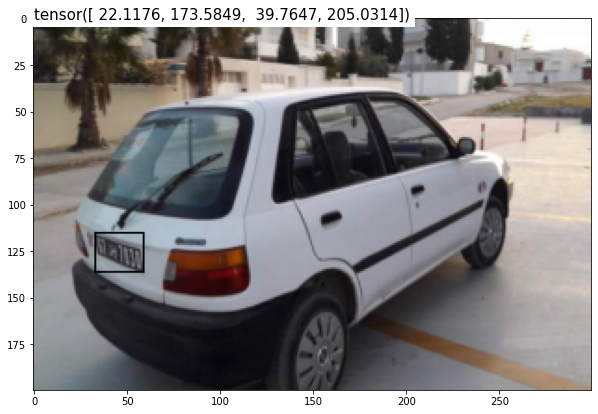

In [ ]:
image = read_image(currentDirPath + "TrainingData/D1/Images/1.jpg")
csv = pd.read_csv(currentDirPath + "TrainingData/D1/D1.csv")

orginal_size = image.shape[1:]

transformation = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((200,300)),
      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])                                   
])
image = transformation(image)
bb = torch.tensor([csv.iloc[0]["ymin"]/orginal_size[0],csv.iloc[0]["xmin"]/orginal_size[1],csv.iloc[0]["ymax"]/orginal_size[0],csv.iloc[0]["xmax"]/orginal_size[1]], dtype=torch.float32)
ShowImageWithBoundingBox(bb, image, (200,300))

**Dataset**

In [ ]:
class cardataset(Dataset):
  def __init__(self, data, sizeTuple):
    self.data = data
    self.size = sizeTuple
    self.imageReadPath = currentDirPath + "TrainingData/D1/Images/"
    self.transformation = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize(self.size),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])                                   
    ])

  def __len__(self):
      return len(self.data["img_id"])

  def __getitem__(self, idx):
    
    imagePath = self.imageReadPath + self.data.iloc[idx]["img_id"]
    image = read_image(imagePath)
    original_size = image.shape[1:]
    #print(original_size)
    image = self.transformation(image)
    image = image.type(torch.float32)
    borderbox = create_bb_array(self.data.iloc[idx])
    borderbox = torch.tensor([borderbox[0]/original_size[0], borderbox[1]/original_size[1],borderbox[2]/original_size[0], borderbox[3]/original_size[1]], dtype=torch.float32)
    #print(borderbox)
    return image, borderbox


**Dataloader and train/val split**

In [ ]:
data = pd.read_csv(currentDirPath + "TrainingData/D1/D1.csv")

#print(data.iloc[665]["img_id"])
x_train, x_val = train_test_split(data[['img_id', 'ymin','xmin','ymax','xmax']], test_size=0.2, random_state=18)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)

#data = data.reset_index(drop=True)

dset = cardataset(x_train, (200,300))

valset = cardataset(x_val, (200,300))

carsTrainLoader = torch.utils.data.DataLoader(dset, batch_size=16,
                                        shuffle=True, num_workers=2)
carsValLoader = torch.utils.data.DataLoader(valset, batch_size=16,
                                        shuffle=True, num_workers=2)

**Dataloader enumerator test**

In [ ]:
for i, data in enumerate(carsTrainLoader):
  image, bb = data
  print(bb)


**Model with resnet**

In [ ]:
class CarsModel(nn.Module):
    def __init__(self):
        super(CarsModel, self).__init__()        
        self.resnet = models.resnet34(pretrained=True)

        self.net = torch.nn.Sequential(
            #torch.nn.Flatten(start_dim=0),
            torch.nn.Linear(1000, 750),
            torch.nn.Linear(750, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 4),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.net(x)
        return x

In [ ]:
nettest = CarsModel()

**Model, loss function and optimizer instansiation**

In [ ]:
net = CarsModel()
#Loss function 
criterion = nn.MSELoss()#nn.CrossEntropyLoss()#F.binary_cross_entropy#nn.KLDivLoss()
#Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

**Training loop**

In [ ]:
running_loss = 0.0
for epoch in range(100):  # loop over the dataset multiple times

    for i, data in enumerate(carsTrainLoader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        #print(outputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if(i % 50 == 0):
          print("Loss: " + str(running_loss))
    print("Current Epoch:" + str(epoch) + "; Current loss:" + str(running_loss))

print('Finished Training')

Loss: 0.024074790999293327
Current Epoch:0; Current loss:1.16579800657928
Loss: 1.1849895510822535
Current Epoch:1; Current loss:2.223412115126848
Loss: 2.2448595706373453
Current Epoch:2; Current loss:3.203501713462174
Loss: 3.2217916948720813
Current Epoch:3; Current loss:4.121186814270914
Loss: 4.137281461618841
Current Epoch:4; Current loss:5.003114392049611
Loss: 5.019659110344946
Current Epoch:5; Current loss:5.8535302728414536
Loss: 5.873780434951186
Current Epoch:6; Current loss:6.682405334897339
Loss: 6.700538790784776
Current Epoch:7; Current loss:7.49181636236608
Loss: 7.502810091711581
Current Epoch:8; Current loss:8.284108525142074
Loss: 8.294066249392927
Current Epoch:9; Current loss:9.067322223447263
Loss: 9.082461933605373
Current Epoch:10; Current loss:9.8327645836398
Loss: 9.842811689712107
Current Epoch:11; Current loss:10.585938469972461
Loss: 10.595612721983343
Current Epoch:12; Current loss:11.321088874246925
Loss: 11.335635665338486
Current Epoch:13; Current loss

KeyboardInterrupt: ignored

**Validation**

In [ ]:
total_loss = 0
with torch.no_grad():
    for i, data in enumerate(carsTrainLoader, 0):
        inputs, targets = data
        #print(inputs.shape)
        #print(targets.shape)    
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        if(i % 20 == 0):
          print(f"running loss: {total_loss:.3f}")
    print(f"Total loss: {total_loss:.3f}")



running loss: 0.017
running loss: 0.301
running loss: 0.570
Total loss: 0.629


**Normal validation set plot**

In [ ]:
for entry in list(carsValLoader.dataset)[:1]:
  ShowImageWithBoundingBox(entry[1], entry[0], (200,300))

**Model prediction plot**

In [ ]:
for entry in list(carsValLoader.dataset)[:5]:
  image = entry[0].unsqueeze(dim=0)
  print(image.shape)
  imageflat = image.flatten(start_dim=1)
  print(imageflat.shape)
  #pred = nettest(image)[0]
  pred = net(image)[0]
  print(pred)
  ShowImageWithBoundingBox(pred, entry[0], (200,300))

Output hidden; open in https://colab.research.google.com to view.